# The Keras Functional API

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

## Input layers

The first step in creating a neural network model is to define the Input layer. This layer takes in raw data, usually in the form of numpy arrays. The shape of the Input layer defines how many variables your neural network will use. For example, if the input data has 10 columns, you define an Input layer with a shape of (10,).

In this case, you are only using one input in your network.

In [2]:
# Import Input from keras.layers
from keras.layers import Input

# Create an input layer of shape 1
input_tensor = Input(shape=(1,))

Using TensorFlow backend.


## Dense layers

Once you have an Input layer, the next step is to add a Dense layer.

Dense layers learn a weight matrix, where the first dimension of the matrix is the dimension of the input data, and the second dimension is the dimension of the output data. Recall that your Input layer has a shape of 1. In this case, your output layer will also have a shape of 1. This means that the Dense layer will learn a 1x1 weight matrix.

In this exercise, you will add a dense layer to your model, after the input layer.

In [3]:
# Load layers
from keras.layers import Input, Dense

# Input layer (from previous exercise)
input_tensor = Input(shape=(1,))

# Create a dense layer
output_layer = Dense(1)

# Connect the dense layer to the input_tensor
output_tensor = output_layer(input_tensor)

## Output layers

Output layers are simply Dense layers! Output layers are used to reduce the dimension of the inputs to the dimension of the outputs. You'll learn more about output dimensions in chapter 4, but for now, you'll always use a single output in your neural networks, which is equivalent to Dense(1) or a dense layer with a single unit.

In [4]:
# Load layers
from keras.layers import Input, Dense

# Input layer
input_tensor = Input(shape=(1,))

# Create a dense layer and connect the dense layer to the input_tensor in one step
# Note that you did this in 2 steps in the previous exercise, but are doing it in one step now
output_tensor = Dense(1)(input_tensor)

## Build a model

Once you've defined an input layer and an output layer, you can build a Keras model. The model object is how you tell Keras where the model starts and stops: where data comes in and where predictions come out.

In [5]:
# Input/dense/output layers
from keras.layers import Input, Dense
input_tensor = Input(shape=(1,))
output_tensor = Dense(1)(input_tensor)

# Build the model
from keras.models import Model
model = Model(input_tensor, output_tensor)

## Compile a model

The final step in creating a model is compiling it. Now that you've created a model, you have to compile it before you can fit it to data. This finalizes your model, freezes all its settings, and prepares it to meet some data!

During compilation, you specify the optimizer to use for fitting the model to the data, and a loss function. 'adam' is a good default optimizer to use, and will generally work well. Loss function depends on the problem at hand. Mean squared error is a common loss function and will optimize for predicting the mean, as is done in least squares regression.

Mean absolute error optimizes for the median and is used in quantile regression. For this dataset, 'mean_absolute_error' works pretty well, so use it as your loss function.

In [6]:
# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

## Visualize a model

Now that you've compiled the model, take a look a the result of your hard work! You can do this by looking at the model summary, as well as its plot.

The summary will tell you the names of the layers, as well as how many units they have and how many parameters are in the model.

The plot will show how the layers connect to each other.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


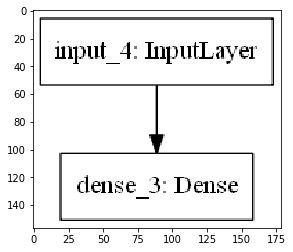

In [7]:
# Import the plotting function
from keras.utils import plot_model
import matplotlib.pyplot as plt

# Summarize the model
model.summary()

# Plot the model
plot_model(model, to_file='model.png')

# Display the image
data = plt.imread('model.png')
plt.imshow(data)
plt.show()

## Fit the model to the tournament basketball data

Now that the model is compiled, you are ready to fit it to some data!

In this exercise, you'll use a dataset of scores from US College Basketball tournament games. Each row of the dataset has the team ids: team_1 and team_2, as integers. It also has the seed difference between the teams (seeds are assigned by the tournament committee and represent a ranking of how strong the teams are) and the score difference of the game (e.g. if team_1 wins by 5 points, the score difference is 5).

To fit the model, you provide a matrix of X variables (in this case one column: the seed difference) and a matrix of Y variables (in this case one column: the score difference).

The games_tourney DataFrame along with the compiled model object is available in your workspace.

In [9]:
games_tourney_train = pd.read_csv('41Data.csv')

In [10]:
# Now fit the model
model.fit(games_tourney_train['seed_diff'], games_tourney_train['score_diff'],
          epochs=1,
          batch_size=128,
          validation_split=0.10,
          verbose=True)

Train on 3810 samples, validate on 424 samples
Epoch 1/1
3810/3810 [==============================] - 4s 996us/step - loss: 12.2570 - val_loss: 11.9987


## Evaluate the model on a test set

After fitting the model, you can evaluate it on new data. You will give the model a new X matrix (also called test data), allow it to make predictions, and then compare to the known y variable (also called target data).

In this case, you'll use data from the post-season tournament to evaluate your model. The tournament games happen after the regular season games you used to train our model, and are therefore a good evaluation of how well your model performs out-of-sample.

The games_tourney_test DataFrame along with the fitted model object is available in your workspace.

In [12]:
games_tourney_test = pd.read_csv('41Data1.csv')

In [13]:
# Load the X variable from the test data
X_test = games_tourney_test['seed_diff']

# Load the y variable from the test data
y_test = games_tourney_test['score_diff']

# Evaluate the model on the test data
model.evaluate(X_test, y_test)

804/804 [==============================] - 0s 40us/step


11.742286231387315

# Two Input Networks Using Categorical Embeddings, Shared Layers, and Merge Layers

## Define team lookup

Shared layers allow a model to use the same weight matrix for multiple steps. In this exercise, you will build a "team strength" layer that represents each team by a single number. You will use this number for both teams in the model. The model will learn a number for each team that works well both when the team is team_1 and when the team is team_2 in the input data.

The games_season DataFrame is available in your workspace.

In [15]:
games_season = pd.read_csv('41Data2.csv')

In [16]:
# Imports
from keras.layers import Embedding
from numpy import unique

# Count the unique number of teams
n_teams = unique(games_season['team_1']).shape[0]

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

## Define team model

The team strength lookup has three components: an input, an embedding layer, and a flatten layer that creates the output.

If you wrap these three layers in a model with an input and output, you can re-use that stack of three layers at multiple places.

Note again that the weights for all three layers will be shared everywhere we use them.

In [17]:
# Imports
from keras.layers import Input, Embedding, Flatten
from keras.models import Model

# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

## Defining two inputs

In this exercise, you will define two input layers for the two teams in your model. This allows you to specify later in the model how the data from each team will be used differently.

In [18]:
# Load the input layer from keras.layers
from keras.layers import Input

# Input layer for team 1
team_in_1 = Input(shape=(1,), name='Team-1-In')

# Separate input layer for team 2
team_in_2 = Input(shape=(1,), name='Team-2-In')

## Lookup both inputs in the same model

Now that you have a team strength model and an input layer for each team, you can lookup the team inputs in the shared team strength model. The two inputs will share the same weights.

In this dataset, you have 10,888 unique teams. You want to learn a strength rating for each team, such that if any pair of teams plays each other, you can predict the score, even if those two teams have never played before. Furthermore, you want the strength rating to be the same, regardless of whether the team is the home team or the away team.

To achieve this, you use a shared layer, defined by the re-usable model (team_strength_model()) you built in exercise 3 and the two input layers (team_in_1 and team_in_2) from the previous exercise, all of which are available in your workspace.

In [19]:
# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)

## Output layer using shared layer

Now that you've looked up how "strong" each team is, subtract the team strengths to determine which team is expected to win the game.

This is a bit like the seeds that the tournament committee uses, which are also a measure of team strength. But rather than using seed differences to predict score differences, you'll use the difference of your own team strength model to predict score differences.

The subtract layer will combine the weights from the two layers by subtracting them.

In [20]:
# Import the Subtract layer from keras
from keras.layers import Subtract

# Create a subtract layer using the inputs from the previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

## Model using two inputs and one output

Now that you have your two inputs (team id 1 and team id 2) and output (score difference), you can wrap them up in a model so you can use it later for fitting to data and evaluating on new data.

Your model will look like the following diagram:



In [22]:
# Imports
from keras.layers import Subtract
from keras.models import Model

# Subtraction layer from previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

## Fit the model to the regular season training data

Now that you've defined a complete team strength model, you can fit it to the basketball data! Since your model has two inputs now, you need to pass the input data as a list.

In [23]:
# Get the team_1 column from the regular season data
input_1 = games_season['team_1']

# Get the team_2 column from the regular season data
input_2 = games_season['team_2']

# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1, input_2],
          games_season['score_diff'],
          epochs=1,
          batch_size=2048,
          validation_split=0.10,
          verbose=True)

Train on 280960 samples, validate on 31218 samples
Epoch 1/1
280960/280960 [==============================] - 1s 2us/step - loss: 12.1200 - val_loss: 11.8375


## Evaluate the model on the tournament test data

The model you fit to the regular season data (model) in the previous exercise and the tournament dataset (games_tourney) are available in your workspace.

In this exercise, you will evaluate the model on this new dataset. This evaluation will tell you how well you can predict the tournament games, based on a model trained with the regular season data. This is interesting because many teams play each other in the tournament that did not play in the regular season, so this is a very good check that your model is not overfitting.

In [25]:
games_tourney = pd.read_csv('41Data3.csv')

In [26]:
# Get team_1 from the tournament data
input_1 = games_tourney['team_1']

# Get team_2 from the tournament data
input_2 = games_tourney['team_2']

# Evaluate the model using these inputs
model.evaluate([input_1, input_2], games_tourney['score_diff'])

4234/4234 [==============================] - 0s 45us/step


11.68089143296261

# Multiple Inputs: 3 Inputs (and Beyond!)

## Make an input layer for home vs. away

Now you will make an improvement to the model you used in the previous chapter for regular season games. You know there is a well-documented home-team advantage in basketball, so you will add a new input to your model to capture this effect.

This model will have three inputs: team_id_1, team_id_2, and home. The team IDs will be integers that you look up in your team strength model from the previous chapter, and home will be a binary variable, 1 if team_1 is playing at home, 0 if they are not.

The team_strength_model you used in the previous chapter has been loaded into your workspace. After applying it to each input, use a Concatenate layer to join the two team strengths and with the home vs away variable, and pass the result to a Dense layer.

In [27]:
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

NameError: name 'Concatenate' is not defined

## Make a model and compile it

Now that you've input and output layers for the 3-input model, wrap them up in a Keras model class, and then compile the model, so you can fit it to data and use it to make predictions on new data.

In [28]:
# Import the model class
from keras.models import Model

# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

NameError: name 'out' is not defined

## Fit the model and evaluate

Now that you've defined a new model, fit it to the regular season basketball data.

Use the model you fit in the previous exercise (which was trained on the regular season data) and evaluate the model on data for tournament games (games_tourney).

In [29]:
# Fit the model to the games_season dataset
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=1,
          verbose=True,
          validation_split=.10,
          batch_size=2048)

# Evaluate the model on the games_tourney dataset
model.evaluate([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']],
               games_tourney['score_diff'])

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 3 arrays: [array([[3745],
       [ 126],
       [ 288],
       ...,
       [9730],
       [8813],
       [3437]], dtype=int64), array([[6664],
       [7493],
       [3593],
       ...,
       [3233],
       [42...

## Model summaries

In this exercise, you will take a closer look at the summary of one of your 3-input models available in your workspace as model. Note how many layers the model has, how many parameters it has, and how many of those parameters are trainable/non-trainable.

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
Team-Strength-Model (Model)     (None, 1)            10888       Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]                  
__________________________________________________________________________________________________
subtract_2 (Subtract)           (None, 1)            0           Team-Strength-Model[1][0]        
          

## Plotting models

In addition to summarizing your model, you can also plot your model to get a more intuitive sense of it. Your model is available in the workspace.

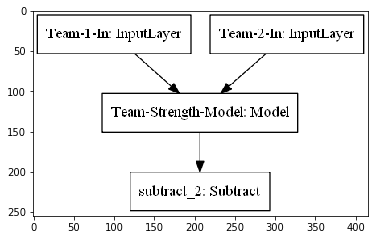

In [31]:
# Imports
import matplotlib.pyplot as plt
from keras.utils import plot_model

# Plot the model
plot_model(model, to_file='model.png')

# Display the image
data = plt.imread('model.png')
plt.imshow(data)
plt.show()

## Add the model predictions to the tournament data

In lesson 1 of this chapter, you used the regular season model to make predictions on the tournament dataset, and got pretty good results! Try to improve your predictions for the tournament by modeling it specifically.

You'll use the prediction from the regular season model as an input to the tournament model. This is a form of "model stacking."

To start, take the regular season model from the previous lesson, and predict on the tournament data. Add this prediction to the tournament data as a new column.

In [32]:
# Predict
games_tourney['pred'] = model.predict([games_tourney['team_1'], 
                                             games_tourney['team_2'], 
                                             games_tourney['home']])

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 3 arrays: [array([[ 288],
       [5929],
       [9884],
       ...,
       [2910],
       [3300],
       [4973]], dtype=int64), array([[   73],
       [   73],
       [   73],
       ...,
       [10818],
      ...

## Create an input layer with multiple columns

In this exercise, you will look at a different way to create models with multiple inputs. This method only works for purely numeric data, but its a much simpler approach to making multi-variate neural networks.

Now you have three numeric columns in the tournament dataset: 'seed_diff', 'home', and 'pred'. In this exercise, you will create a neural network that uses a single input layer to process all three of these numeric inputs.

This model should have a single output to predict the tournament game score difference.

In [33]:
# Create an input layer with 3 columns
input_tensor = Input((3,))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

## Fit the model

Now that you've enriched the tournament dataset and built a model to make use of the new data, fit that model to the tournament data.

Note that this model has only one input layer that is capable of handling all 3 inputs, so it's inputs and outputs do not need to be a list.

Tournament games are split into a training set and a test set. The tournament games before 2010 are in the training set, and the ones after 2010 are in the test set.

In [34]:
# Fit the model
model.fit(games_tourney_train[['home', 'seed_diff', 'pred']],
          games_tourney_train['score_diff'],
          epochs=1,
          verbose=True)

KeyError: "['pred'] not in index"

## Evaluate the model

Now that you've fit your model to the tournament training data, evaluate it on the tournament test data. Recall that the tournament test data contains games from after 2010.

In [35]:
# Evaluate the model on the games_tourney_test dataset
model.evaluate(games_tourney_test[['home', 'seed_diff', 'prediction']], 
               games_tourney_test['score_diff'])

KeyError: "['prediction'] not in index"

# Multiple Outputs

## Simple two-output model

In this exercise, you will use the tournament data to build one model that makes two predictions: the scores of both teams in a given game. Your inputs will be the seed difference of the two teams, as well as the predicted score difference from the model you built in chapter 3.

The output from your model will be the predicted score for team 1 as well as team 2. This is called "multiple target regression": one model making more than one prediction.

In [36]:
# Define the input
input_tensor = Input(shape=(2,))

# Define the output
output_tensor = Dense(2)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')

## Fit a model with two outputs

Now that you've defined your 2-output model, fit it to the tournament data. I've split the data into games_tourney_train and games_tourney_test, so use the training set to fit for now.

This model will use the pre-tournament seeds, as well as your pre-tournament predictions from the regular season model you built previously in this course.

As a reminder, this model will predict the scores of both teams.

In [37]:
model.fit(games_tourney_train[['seed_diff', 'pred']],
  		  games_tourney_train[['score_1', 'score_2']],
  		  verbose=True,
          epochs=100,
  		  batch_size=16384)

KeyError: "['pred'] not in index"

## Inspect the model (I)

Now that you've fit your model, let's take a look at it. You can use the .get_weights() method to inspect your model's weights.

The input layer will have 4 weights: 2 for each input times 2 for each output.

The output layer will have 2 weights, one for each output.

In [38]:
# Print the model's weights
print(model.get_weights())

# Print the column means of the training data
print(games_tourney_train.mean())

[array([[-0.9100033,  1.1159106],
       [-1.0244179,  0.8735579]], dtype=float32), array([0., 0.], dtype=float32)]
Unnamed: 0    2116.500000
season        2001.193198
team_1        5589.146906
team_2        5589.146906
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.131318
score_2         71.131318
won              0.500000
dtype: float64


## Evaluate the model

Now that you've fit your model and inspected it's weights to make sure it makes sense, evaluate it on the tournament test set to see how well it performs on new data.

In [39]:
model.evaluate(games_tourney_test[['seed_diff', 'pred']],
               games_tourney_test[['score_1', 'score_2']])

KeyError: "['pred'] not in index"

## Classification and regression in one model

Now you will create a different kind of 2-output model. This time, you will predict the score difference, instead of both team's scores and then you will predict the probability that team 1 won the game. This is a pretty cool model: it is going to do both classification and regression!

In this model, turn off the bias, or intercept for each layer. Your inputs (seed difference and predicted score difference) have a mean of very close to zero, and your outputs both have means that are close to zero, so your model shouldn't need the bias term to fit the data well.

In [40]:
# Create an input layer with 2 columns
input_tensor = Input(shape=(2,))

# Create the first output
output_tensor_1 = Dense(1, activation='linear', use_bias=False)(input_tensor)

# Create the second output (use the first output as input here)
output_tensor_2 = Dense(1, activation='sigmoid', use_bias=False)(output_tensor_1)

# Create a model with 2 outputs
model = Model(input_tensor, [output_tensor_1, output_tensor_2])

## Compile and fit the model

Now that you have a model with 2 outputs, compile it with 2 loss functions: mean absolute error (MAE) for 'score_diff' and binary cross-entropy (also known as logloss) for 'won'. Then fit the model with 'seed_diff' and 'pred' as inputs. For outputs, predict 'score_diff' and 'won'.

This model can use the scores of the games to make sure that close games (small score diff) have lower win probabilities than blowouts (large score diff).

The regression problem is easier than the classification problem because MAE punishes the model less for a loss due to random chance. For example, if score_diff is -1 and won is 0, that means team_1 had some bad luck and lost by a single free throw. The data for the easy problem helps the model find a solution to the hard problem.

In [41]:
# Import the Adam optimizer
from keras.optimizers import Adam

# Compile the model with 2 losses and the Adam optimzer with a higher learning rate
model.compile(loss=['mean_absolute_error', 'binary_crossentropy'], optimizer=Adam(.01))

# Fit the model to the tournament training data, with 2 inputs and 2 outputs
model.fit(games_tourney_train[['seed_diff', 'pred']],
          [games_tourney_train[['score_diff']], games_tourney_train[['won']]],
          epochs=10,
          verbose=True,
          batch_size=16384)

KeyError: "['pred'] not in index"

## Inspect the model (II)

Now you should take a look at the weights for this model. In particular, note the last weight of the model. This weight converts the predicted score difference to a predicted win probability. If you multiply the predicted score difference by the last weight of the model and then apply the sigmoid function, you get the win probability of the game.

In [42]:
# Print the model weights
print(model.get_weights())

# Print the training data means
print(games_tourney_train.mean())

[array([[0.89545286],
       [0.8428062 ]], dtype=float32), array([[-0.23810995]], dtype=float32)]
Unnamed: 0    2116.500000
season        2001.193198
team_1        5589.146906
team_2        5589.146906
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.131318
score_2         71.131318
won              0.500000
dtype: float64


In [43]:
# Import the sigmoid function from scipy
from scipy.special import expit as sigmoid

# Weight from the model
weight = 0.14

# Print the approximate win probability of a predicted close game
print(sigmoid(1 * weight))

# Print the approximate win probability of a predicted blowout game
print(sigmoid(10 * weight))

0.5349429451582145
0.8021838885585818


## Evaluate on new data with two metrics

Now that you've fit your model and inspected its weights to make sure they make sense, evaluate your model on the tournament test set to see how well it does on new data.

Note that in this case, Keras will return 3 numbers: the first number will be the sum of both the loss functions, and then the next 2 numbers will be the loss functions you used when defining the model.

Ready to take your deep learning to the next level? Check out "Convolutional Neural Networks for Image Processing".

In [44]:
# Evaluate the model on new data
model.evaluate(games_tourney_test[['seed_diff', 'pred']],
               [games_tourney_test[['score_diff']], games_tourney_test[['won']]])

KeyError: "['pred'] not in index"